In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
from data_loader import load_main_data, load_movie_titles
from data_transformer import flatten_data
from data_generator import generate_features, generate_biases, generate_user_embeddings, generate_movie_embeddings, generate_movie_embedings_with_genres
from data_splitting import data_split
from update_rules import update_user ,update_movie
from features_update import update_features, update_movie_with_features

import time


all_ratings = "ratings.csv"
all_genres = "movies.csv"

In [11]:
# Loading the main data
start = time.time()
data_user, data_movie, idx_to_user, idx_to_movie, movie_to_idx, user_to_idx = load_main_data(all_ratings)
print("Finished loading main data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Splitting the data into training and testing sets
start = time.time()
data_by_user_train, data_by_user_test, data_by_movie_train = data_split(data_user, data_movie, ratio=0.8)
print("Finished splitting data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Loading movie titles and genres
start = time.time()
genres_of_a_single_movie, list_movies_per_genre, genres_to_idx = load_movie_titles(all_genres, movie_to_idx)  
print("Finished loading movie titles in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the genre data
start = time.time()
genres_flat, index_movie = flatten_data(genres_of_a_single_movie)
print("Finished flattening genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the list of movies per genre
start = time.time()
list_movies_per_genre_flat, index_genres = flatten_data(list_movies_per_genre.values())
print("Finished flattening movies per genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")

Finished loading main data in 2.17 seconds.

Finished splitting data in 0.01 seconds.

Finished loading movie titles in 0.02 seconds.

Finished flattening genre data in 0.00 seconds.

Finished flattening movies per genre data in 0.00 seconds.



In [12]:
def convert_to_typed_list(data_list_of_lists):
    """
    Converts a List[List[Tuple(id, rating)]] into a 
    Numba Typed List[NumpyArray].
    """
    typed_list = List()
    for item in data_list_of_lists:
        # Convert tuples to a 2D numpy array of float64
        # Shape will be (N_ratings, 2) where col 0 is ID, col 1 is Rating
        if len(item) > 0:
            typed_list.append(np.array(item, dtype=np.float64))
        else:
            # Handle empty users/movies by adding an empty array
            typed_list.append(np.zeros((0, 2), dtype=np.float64))
    return typed_list

print("Converting data to Numba-friendly structures...")
start = time.time()
# Convert all 4 data structures
data_by_user_train_typed = convert_to_typed_list(data_by_user_train)
data_by_user_test_typed = convert_to_typed_list(data_by_user_test)
data_by_movie_train_typed = convert_to_typed_list(data_by_movie_train)
# We don't strictly need typed list for test if not passed to njit, 
# but consistency helps if you optimize evaluation later.

print("Finished conversion in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")

Converting data to Numba-friendly structures...
Finished conversion in 0.52 seconds.



In [13]:
genres_flat[:5]

array([0, 1, 2, 3, 4])

In [14]:
N_iterations = 5*10**1
p_lambda = 1.5
p_gamma = 0.05
user_tau = movie_tau = 2.0
embedding_dim = 5

In [20]:
# Generating features, biases, embeddings
# We will start without the features first
num_users = len(idx_to_user)
num_movies = len(idx_to_movie)

# Biases
user_biases, movie_biases = generate_biases(num_users, num_movies)
print("Shapes of biases - Users: {}, Movies: {}".format(user_biases.shape, movie_biases.shape))

# User embeddings
user_embeddings = generate_user_embeddings(num_users, embedding_dim)
print("Shape of user embeddings: {}".format(user_embeddings.shape))

# Features
features_embedding = generate_features(20, embedding_dim, beta=0.05)
print("Shape of features embeddings : {}".format(features_embedding.shape))
features_embedding = np.array(features_embedding)
# Movie embeddings without genres
# movie_embeddings = generate_movie_embeddings(num_movies, embedding_dim)


movie_embeddings = generate_movie_embedings_with_genres(embedding_dim, genres_flat, index_movie, features_embedding, movie_tau=user_tau)
print("Shape of movie embeddings with genres: {}".format(movie_embeddings.shape))

Shapes of biases - Users: (610,), Movies: (9724,)
Shape of user embeddings: (610, 5)
Shape of features embeddings : (20, 5)
Shape of movie embeddings with genres: (9724, 5)


In [17]:
# @njit(fastmath=True)
def main_loop(N_iterations=N_iterations,
              embedding_dim=embedding_dim,
              data_by_user_train=data_by_user_train,
              data_by_user_test=data_by_user_test,
              data_by_movie_train=data_by_movie_train,
              user_embeddings=user_embeddings,
              user_biases=user_biases,
              movie_embeddings=movie_embeddings,
              movie_biases=movie_biases,
              features_embedding_=features_embedding,
              list_movies_per_genre_flat=list_movies_per_genre_flat,
              genres_flat=genres_flat,
              index_genre=index_genres,
              index_movie=index_movie,
              p_lambda=p_lambda,
              p_gamma=p_gamma,
              user_tau=user_tau,
              movie_tau=movie_tau):
    """
    The main loop for training the model.

    And recording the results.
    """

    N = len(data_by_movie_train)
    M = len(data_by_user_train)

    # Trackers
    error_train = []
    error_test = []
    rmse_train_list = []
    rmse_test_list = []
    error_tracker = []
    
    print("Beginning main loop...")

    # Main loop for training the model would go here
    for iteration in range(N_iterations):

        # Then goes the user embeddings and the user biases update
        user_embeddings, user_biases = update_user(M,
                embedding_dim,
                data_by_user_train,
                movie_embeddings,
                user_embeddings,
                user_biases,
                movie_biases,
                p_lambda=p_lambda,
                user_tau=user_tau)

        movie_embeddings, movie_biases = update_movie_with_features(
            N,
            embedding_dim,
            data_by_movie_train,
            movie_embeddings,
            user_embeddings,
            user_biases,
            movie_biases,
            features_embedding_,
            genres_flat,
            index_movie,
            p_lambda,
            p_gamma,
            movie_tau
        )
        
        # First goes the movie embeddings and the movie biases update
        # movie_embeddings, movie_biases = update_movie(N,
        #          embedding_dim,
        #          data_by_movie_train,
        #          movie_embeddings,
        #          user_embeddings,
        #          user_biases,
        #          movie_biases,
        #          p_lambda=p_lambda,
        #          p_gamma=p_gamma,
        #          user_tau=movie_tau)

        # Here goes the features update
        features_embedding_ = update_features(
                features_embedding,
                movie_embeddings,
                genres_flat,
                index_genre,
                list_movies_per_genre_flat,
                index_movie,
                embedding_dim,
)


        if (iteration + 1) % max(1, (N_iterations // 10)) == 0:
                print("Progressing...")

        if iteration <= 5 or (iteration + 1) % 10 == 0 or (iteration + 1) % 25 == 0:
            err_test = 0.0
            err_train = 0.0
            total_ratings_train = 0
            total_ratings_test = 0

            for user_idx in range(M):
                current_train = data_by_user_train[user_idx]
                num_ratings_train = len(current_train)
                total_ratings_train += num_ratings_train
                if num_ratings_train == 0:
                    continue

                movies_idx = np.empty(num_ratings_train, dtype=np.int64)
                ratings = np.empty(num_ratings_train, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_train):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_train += np.sum((ratings - preds) ** 2)

            for user_idx in range(M):
                current_test = data_by_user_test[user_idx]
                num_ratings_test = len(current_test)
                total_ratings_test += num_ratings_test
                if num_ratings_test == 0:
                    continue

                movies_idx = np.empty(num_ratings_test, dtype=np.int64)
                ratings = np.empty(num_ratings_test, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_test):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_test += np.sum((ratings - preds) ** 2)

            rmse_train_val = 0.0
            rmse_test_val = 0.0
            if total_ratings_train > 0:
                rmse_train_val = np.sqrt(err_train / total_ratings_train)
            if total_ratings_test > 0:
                rmse_test_val = np.sqrt(err_test / total_ratings_test)

            reg_bias = (p_gamma / 2.0) * (np.sum(user_biases ** 2) + np.sum(movie_biases ** 2))
            reg_embed = (user_tau / 2.0) * (np.sum(user_embeddings ** 2) + np.sum(movie_embeddings ** 2))

            err_test_reg = (err_test * (p_lambda / 2.0)) + reg_bias + reg_embed
            err_train_reg = (err_train * (p_lambda / 2.0)) + reg_bias + reg_embed

            error_tracker.append(iteration)
            rmse_train_list.append(rmse_train_val)
            rmse_test_list.append(rmse_test_val)
            error_test.append(err_test_reg)
            error_train.append(err_train_reg)

    return error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, user_biases, movie_biases, user_embeddings, movie_embeddings, features_embedding_

Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 3.41 seconds.



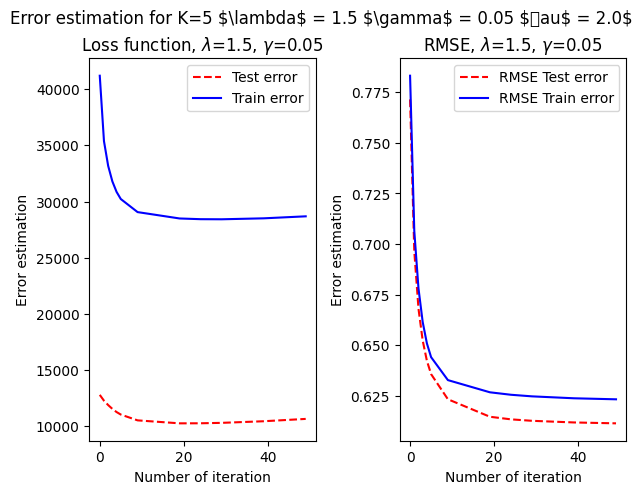

In [21]:
start = time.time()
main_loop_results = main_loop(
    N_iterations=N_iterations,
    embedding_dim=embedding_dim,
    data_by_user_train=data_by_user_train_typed,   # <--- CHANGED
    data_by_user_test=data_by_user_test_typed,     # <--- CHANGED
    data_by_movie_train=data_by_movie_train_typed, # <--- CHANGED
    user_embeddings=user_embeddings,
    features_embedding_=features_embedding,
    user_biases=user_biases,
    movie_embeddings=movie_embeddings,
    movie_biases=movie_biases
)
print("Finished training in {:.2f} seconds.".format(time.time() - start))

(error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, _, _, ue, me, ft) = main_loop_results
print("=" * 25, "\n")
# print(error_tracker,'\n', error_test,'\n', error_train,'\n', rmse_test_list,'\n', rmse_train_list)



fig, ax = plt.subplots(1,2)
ax[0].plot(error_tracker, error_test, color="red", linestyle="dashed", label="Test error")
ax[0].plot(error_tracker, error_train, color="blue", linestyle="solid", label="Train error")
ax[0].set_xlabel("Number of iteration")
ax[0].set_ylabel("Error estimation")
ax[0].set_title(f"Loss function, $\lambda$={p_lambda}, $\gamma$={p_gamma}")
ax[0].legend(loc="upper right")


ax[1].plot(error_tracker, rmse_test_list, color="red", linestyle="dashed", label="RMSE Test error")
ax[1].plot(error_tracker, rmse_train_list, color="blue", linestyle="solid", label="RMSE Train error")
ax[1].set_xlabel("Number of iteration")
ax[1].set_ylabel("Error estimation")
ax[1].set_title(f"RMSE, $\lambda$={p_lambda}, $\gamma$={p_gamma}")
ax[1].legend(loc="upper right")

# plt.savefig(f"Error_{embedding_dim}_local_{p_lambda}_{p_gamma}_{user_tau}_func_big_no_feat.pdf")
plt.tight_layout()
plt.suptitle(f"Error estimation for K={embedding_dim} $\lambda$ = {p_lambda} $\gamma$ = {p_gamma} $\tau$ = {user_tau}$", y=1.02)
plt.show()

In [22]:
ue.shape

(610, 5)

In [23]:
ft.shape

(20, 5)

In [24]:
me.shape

(9724, 5)